# Expedia - Predicting Yearly Availability

In [1]:
# To install packages that are not installed by default, uncomment the last two lines 
# of this cell and replace <package list> with a list of necessary packages.
# This will ensure the notebook has all the dependencies and works everywhere.

import sys
!{sys.executable} -m pip install <package list>

zsh:1: parse error near `>'


In [2]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

## Data Wrangling & Visualization

In [4]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [5]:
data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1


In [6]:
#Explore columns
data.columns

Index(['id', 'region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id',
       'owned_hotels', 'yearly_availability'],
      dtype='object')

In [7]:
#Description
data.describe()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
count,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2194.000000,2.870000e+03,2870.000000,2870.000000
mean,26760.657143,40.731224,-73.950158,195.943206,11.530314,16.315331,1.157502,7.202195e+07,8.411498,0.498606
std,14140.930062,0.054942,0.049745,406.184714,37.972339,32.481722,1.355028,8.076516e+07,27.105522,0.500085
min,0.000000,40.507080,-74.242850,10.000000,1.000000,0.000000,0.010000,2.787000e+03,1.000000,0.000000
25%,15931.750000,40.692463,-73.984003,75.000000,1.000000,1.000000,0.240000,7.388002e+06,1.000000,0.000000
50%,28946.500000,40.728250,-73.956720,120.000000,3.000000,4.000000,0.650000,3.352708e+07,1.000000,0.000000
75%,38478.500000,40.762658,-73.934202,200.000000,6.000000,16.000000,1.530000,1.207625e+08,3.000000,1.000000
max,48893.000000,40.898730,-73.721730,9999.000000,999.000000,395.000000,10.370000,2.738123e+08,327.000000,1.000000


In [8]:
#checking the data types, missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2870 non-null   int64  
 1   region               2870 non-null   object 
 2   latitude             2870 non-null   float64
 3   longitude            2870 non-null   float64
 4   accommodation_type   2870 non-null   object 
 5   cost                 2870 non-null   int64  
 6   minimum_nights       2870 non-null   int64  
 7   number_of_reviews    2870 non-null   int64  
 8   reviews_per_month    2194 non-null   float64
 9   owner_id             2870 non-null   int64  
 10  owned_hotels         2870 non-null   int64  
 11  yearly_availability  2870 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 269.2+ KB


In [9]:
#checking for missing values
data.isnull().sum() 

id                       0
region                   0
latitude                 0
longitude                0
accommodation_type       0
cost                     0
minimum_nights           0
number_of_reviews        0
reviews_per_month      676
owner_id                 0
owned_hotels             0
yearly_availability      0
dtype: int64

In [10]:
data["number_of_reviews"].value_counts()

0      676
1      300
2      208
3      146
4      120
      ... 
79       1
155      1
188      1
395      1
112      1
Name: number_of_reviews, Length: 160, dtype: int64

Looks like reviews_per_month are missing values when number_of_reviews equals to zero, which makes a lot of sense logically, but needs to be handled.

In [11]:
data["reviews_per_month"].fillna(0, inplace = True)

<AxesSubplot:>

0    1439
1    1431
Name: yearly_availability, dtype: int64

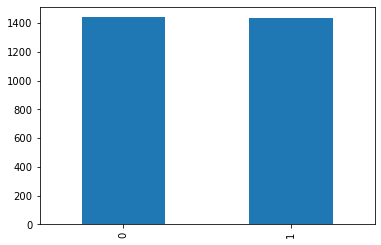

In [12]:
#taking a look and visualizing the variable that we'll need to predict
data["yearly_availability"].value_counts().plot(kind="bar")
data["yearly_availability"].value_counts()

In [13]:
# new feature
data["no_yearly_availability"] = 1 - data["yearly_availability"]

<AxesSubplot:>

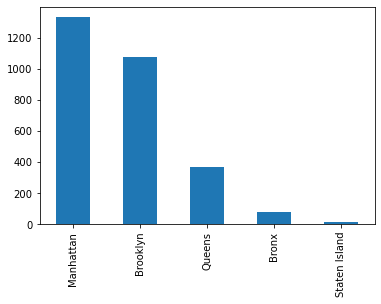

In [14]:
data["region"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='region'>

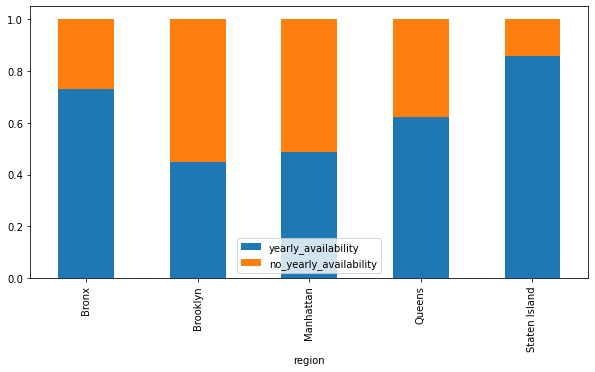

In [15]:
data.groupby("region").agg('mean')[["yearly_availability","no_yearly_availability"]].plot(kind='bar',
                                                            figsize=(10, 5),
                                                            stacked=True)

<AxesSubplot:>

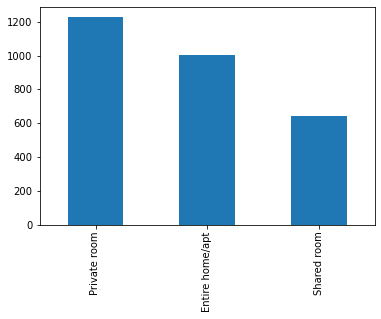

In [16]:
data["accommodation_type"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='accommodation_type'>

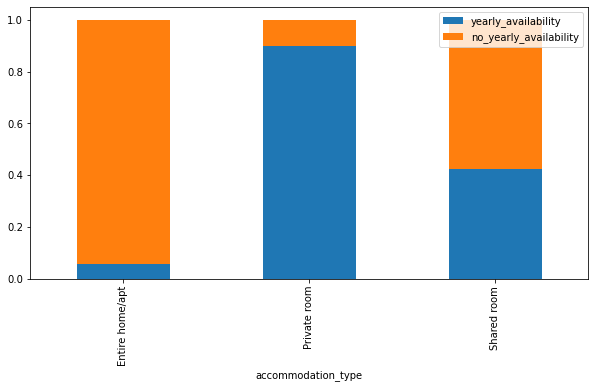

In [17]:
data.groupby("accommodation_type").agg('mean')[["yearly_availability","no_yearly_availability"]].plot(kind='bar',
                                                            figsize=(10, 5),
                                                            stacked=True)

In [18]:
data.groupby("region")["accommodation_type"].value_counts()

region         accommodation_type
Bronx          Private room           47
               Entire home/apt        20
               Shared room            11
Brooklyn       Entire home/apt       422
               Private room          395
               Shared room           258
Manhattan      Private room          591
               Entire home/apt       458
               Shared room           284
Queens         Private room          181
               Entire home/apt       100
               Shared room            89
Staten Island  Private room           11
               Entire home/apt         2
               Shared room             1
Name: accommodation_type, dtype: int64

<AxesSubplot:xlabel='cost', ylabel='Density'>

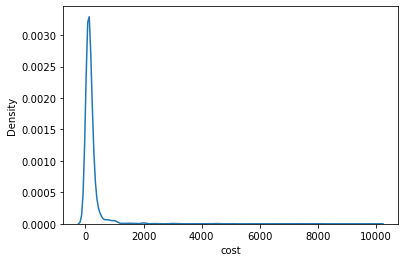

In [19]:
sns.kdeplot(data["cost"])

<AxesSubplot:xlabel='cost'>

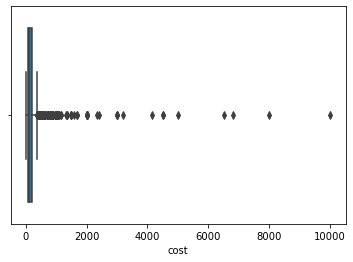

In [20]:
#looking for outliers
sns.boxplot(x=data['cost'])

<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

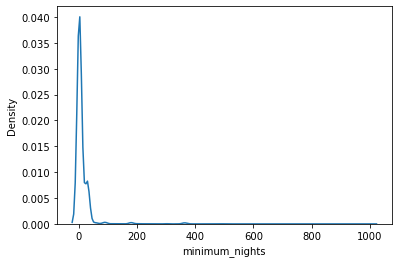

In [21]:
sns.kdeplot(data["minimum_nights"])

<AxesSubplot:xlabel='minimum_nights'>

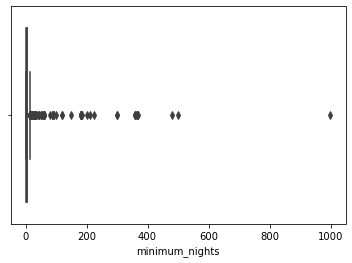

In [22]:
#looking for outliers
sns.boxplot(x=data['minimum_nights'])

<AxesSubplot:xlabel='number_of_reviews', ylabel='Density'>

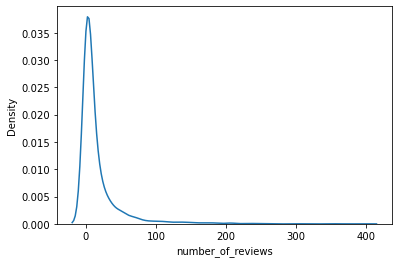

In [23]:
sns.kdeplot(data["number_of_reviews"])

<AxesSubplot:xlabel='number_of_reviews'>

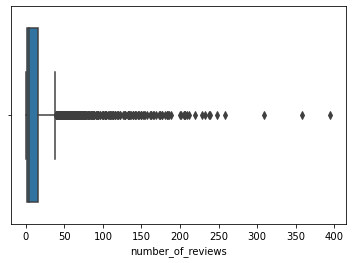

In [24]:
#looking for outliers
sns.boxplot(x=data['number_of_reviews'])

<AxesSubplot:xlabel='reviews_per_month', ylabel='Density'>

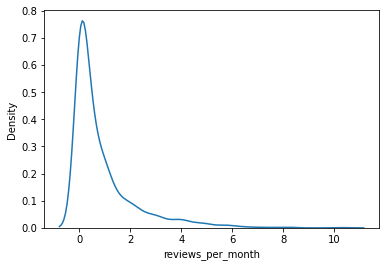

In [25]:
sns.kdeplot(data["reviews_per_month"])

Assuming that each owner is not nesseserally putting all of the hotels they own on Travel Express, would be interesting to see how many listings each owner has on the platform.

In [26]:
#checking if any of the owners have more than one property on the platform
data["owner_id"].value_counts()

30283594     31
200380610    29
2856748      25
120762452    22
22541573     20
             ..
111938058     1
243489234     1
12906455      1
29746291      1
10903067      1
Name: owner_id, Length: 2371, dtype: int64

In [27]:
#Let's use this to add another feature
data["owned_hotels_on_the_platform"] = data.groupby(["owner_id"])['id'].transform('count')

<AxesSubplot:>

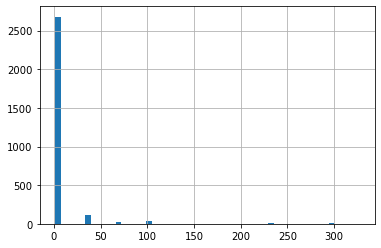

In [28]:
data["owned_hotels"].hist(width=6)

In [29]:
data.drop(["no_yearly_availability"],axis=1,inplace=True)

In [30]:
correlations = data.corr(method='spearman')
print(correlations["yearly_availability"].sort_values(ascending=False),'\n')

yearly_availability             1.000000
owned_hotels_on_the_platform    0.425313
owned_hotels                    0.421031
cost                            0.117698
owner_id                        0.092594
minimum_nights                  0.086592
longitude                       0.076259
latitude                       -0.012907
id                             -0.151001
number_of_reviews              -0.320168
reviews_per_month              -0.405676
Name: yearly_availability, dtype: float64 



I will use owned_hotels_on_the_platform, owned_hotels, number_of_reviews and reviews_per_month since they showed correlation.

## Visualization, Modeling, Machine Learning

Building a model that categorizes hotels on the basis of their yearly availability. 

In [31]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,NaN,13773574,12
3,33694,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,28873,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2


In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  718 non-null    int64  
 1   region              718 non-null    object 
 2   latitude            718 non-null    float64
 3   longitude           718 non-null    float64
 4   accommodation_type  718 non-null    object 
 5   cost                718 non-null    int64  
 6   minimum_nights      718 non-null    int64  
 7   number_of_reviews   718 non-null    int64  
 8   reviews_per_month   545 non-null    float64
 9   owner_id            718 non-null    int64  
 10  owned_hotels        718 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 61.8+ KB


In [33]:
test_data.isnull().sum() 

id                      0
region                  0
latitude                0
longitude               0
accommodation_type      0
cost                    0
minimum_nights          0
number_of_reviews       0
reviews_per_month     173
owner_id                0
owned_hotels            0
dtype: int64

In [34]:
#handling null values 
test_data["reviews_per_month"].fillna(0, inplace = True)

In [35]:
#adding the same feature as in the train set
test_data["owned_hotels_on_the_platform"] = test_data.groupby(["owner_id"])['id'].transform('count')

<AxesSubplot:>

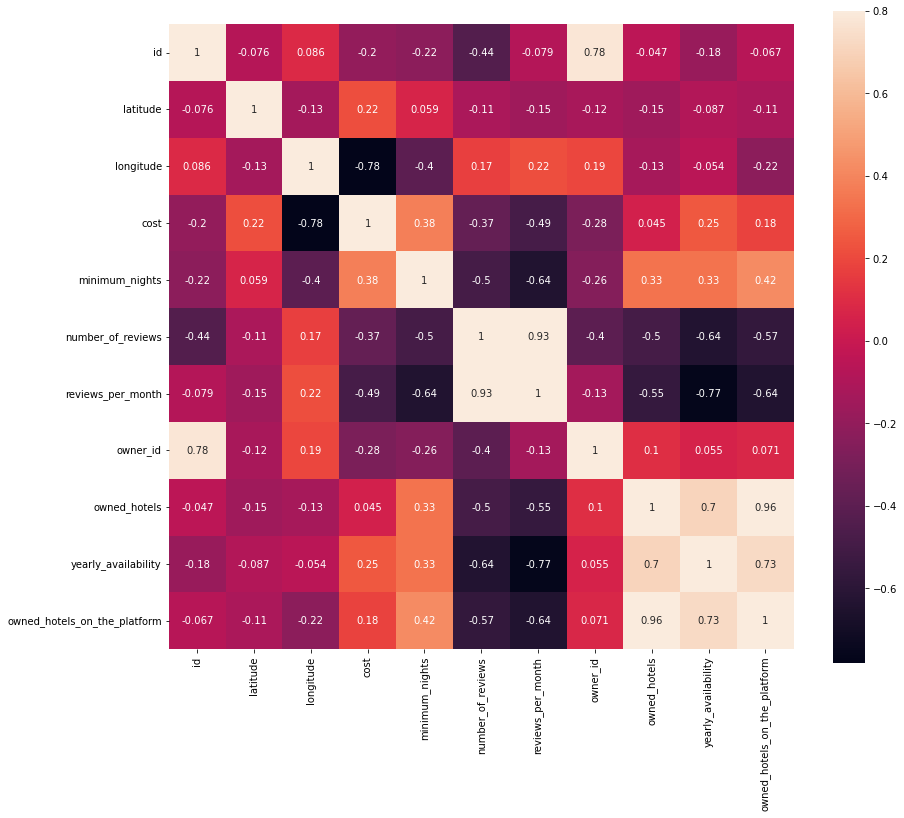

In [36]:
cm = np.corrcoef(correlations.values.T)
f,ax = plt.subplots(figsize=(14,12))
sns.heatmap(cm, square=True, vmax=0.8,annot=True, xticklabels=correlations,yticklabels=correlations)

### Conclusion:
According to the heatmap above, the hotel owners with a higher number of the hotels owned in general and hotels on the platform in particular, tend to commit to the all year availability, while the owners with low number of reviews in total and average reviews per month, tend to take the listing off. Hence these features will be used for prediction.

In [37]:
# Target and features
trainFeat = data[['yearly_availability','owned_hotels_on_the_platform','owned_hotels','number_of_reviews','reviews_per_month']]
# test data
testDat = trainFeat.sample(n=100,random_state=7)
# training data
train = trainFeat[~(trainFeat.index).isin(testDat.index)]
# Check to make sure that test and training data don't overlap
any(train.index.isin(testDat.index))

False

In [38]:
#shuffling data
np.random.seed(9)
newseq=np.random.permutation(len(train))
trainD=train.iloc[newseq,:]

In [39]:
trainD.columns

Index(['yearly_availability', 'owned_hotels_on_the_platform', 'owned_hotels',
       'number_of_reviews', 'reviews_per_month'],
      dtype='object')

In [40]:
testD=test_data[['owned_hotels_on_the_platform','owned_hotels','number_of_reviews','reviews_per_month']]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    trainD.drop(['yearly_availability'], axis=1),
    trainD.yearly_availability,
    test_size= 0.2,
    random_state=0,
    stratify=trainD.yearly_availability
)

In [42]:
# Logistic regression
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

Y_pred = clf.predict(X_test)
accuracy_score(y_test, Y_pred)

LogisticRegression()

0.7148014440433214

In [43]:
cm=confusion_matrix(y_test, Y_pred)
cm

array([[211,  67],
       [ 91, 185]])

<AxesSubplot:>

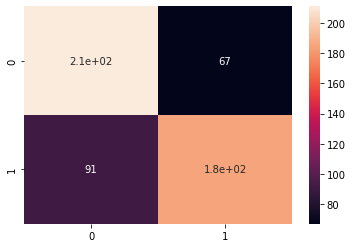

In [44]:
sns.heatmap(cm,annot=True)

In [45]:
pred = clf.predict(testD)

In [46]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,

In [47]:
resuts_df = pd.DataFrame({
        "id": test_data["id"],
        "yearly_availability": pred
    })

In [48]:
#Final results
results_df.to_csv('submissions.csv',index=False)

---